In [38]:
!pip install -U datasets==2.21.0


In [39]:
!pip install -U numpy==1.26.4 pandas==2.2.2 requests==2.32.4 pyarrow==16.1.0 huggingface-hub==0.23.0



  Using cached huggingface_hub-0.23.0-py3-none-any.whl.metadata (12 kB)
Using cached huggingface_hub-0.23.0-py3-none-any.whl (401 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.34.0
    Uninstalling huggingface-hub-0.34.0:
      Successfully uninstalled huggingface-hub-0.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.57.1 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 0.23.0 which is incompatible.
diffusers 0.35.2 requires huggingface-hub>=0.34.0, but you have huggingface-hub 0.23.0 which is incompatible.
peft 0.17.1 requires huggingface_hub>=0.25.0, but you have huggingface-hub 0.23.0 which is incompatible.
gradio 5.49.1 requires huggingface-hub<2.0,>=0.33.5, but you have huggingface-hub 0.23.0 which is incompatible.


In [40]:
!pip install -U huggingface-hub==0.34.0 fsspec==2025.3.0


  Using cached huggingface_hub-0.34.0-py3-none-any.whl.metadata (14 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
Using cached huggingface_hub-0.34.0-py3-none-any.whl (558 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.23.0
    Uninstalling huggingface-hub-0.23.0:
      Successfully uninstalled huggingface-hub-0.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires fsspec[http]<=2024.6.1,>=2023.1.0, but you have fsspec 2025.3.0 which is incompatible.


In [41]:
from datasets import load_dataset, Audio
from itertools import islice
import csv, re

# стрімлю, бо немає стільки пам'яті
ds_stream = load_dataset("google/fleurs", "en_us", split="train", streaming=True)
ds_stream = ds_stream.cast_column("audio", Audio(decode=True))

OUT_CSV = "/content/fleurs_stream_clean.csv"

def clean_text(t: str) -> str:
    t = t.strip().lower()
    t = re.sub(r"[^a-z0-9'.,?!\s]", "", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

MAX_ROWS = 5000 # тут можна мінять
MIN_SEC, MAX_SEC = 1.0, 15.0

with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["duration_sec", "text"])
    for ex in islice(ds_stream, MAX_ROWS):
        audio = ex["audio"]
        dur = len(audio["array"]) / audio["sampling_rate"]
        if dur < MIN_SEC or dur > MAX_SEC:
            continue
        txt = clean_text(ex["transcription"])
        w.writerow([f"{dur:.3f}", txt])

print("записано", OUT_CSV)


записано /content/fleurs_stream_clean.csv


In [42]:
import pandas as pd
df = pd.read_csv("/content/fleurs_stream_clean.csv")

df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
n = len(df)
train_end = int(0.8 * n)
val_end = int(0.9 * n)
df_train = df.iloc[:train_end]
df_val   = df.iloc[train_end:val_end]
df_test  = df.iloc[val_end:]
print(len(df_train), len(df_val), len(df_test))

1884 235 236


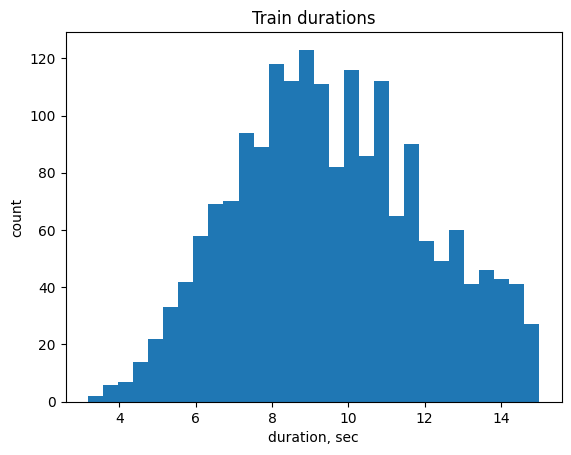

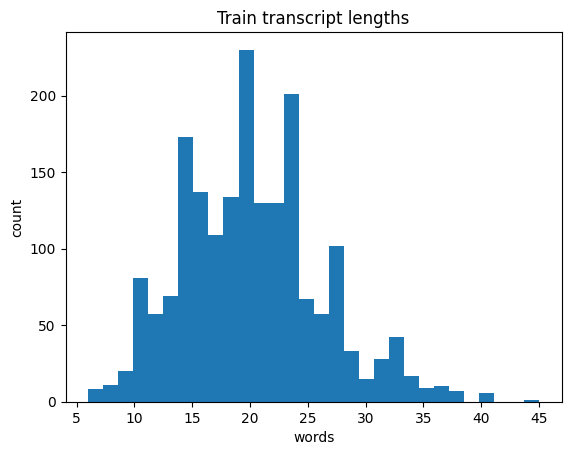

In [43]:
import matplotlib.pyplot as plt
plt.hist(df_train["duration_sec"], bins=30)
plt.xlabel("duration, sec")
plt.ylabel("count")
plt.title("Train durations")
plt.show()

text_len = df_train["text"].str.split().apply(len)
plt.hist(text_len, bins=30)
plt.xlabel("words")
plt.ylabel("count")
plt.title("Train transcript lengths")
plt.show()


In [44]:
# тут щоб послухати можна було
import os, soundfile as sf

PREVIEW_DIR = "/content/fleurs_preview"
os.makedirs(PREVIEW_DIR, exist_ok=True)
ds_stream = load_dataset("google/fleurs", "en_us", split="train", streaming=True)
ds_stream = ds_stream.cast_column("audio", Audio(decode=True))

for i, ex in enumerate(islice(ds_stream, 30)):
    audio = ex["audio"]
    dur = len(audio["array"]) / audio["sampling_rate"]
    if dur < 1.0 or dur > 15.0:
        continue
    path = os.path.join(PREVIEW_DIR, f"sample_{i:03d}.wav")
    sf.write(path, audio["array"], audio["sampling_rate"])
    with open(path + ".txt", "w") as f:
        f.write(ex["transcription"])
print("30 прикладів збережено")


30 прикладів збережено


/tmp/ipython-input-1793505233.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["split"] = "train"
/tmp/ipython-input-1793505233.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["split"] = "validation"
/tmp/ipython-input-1793505233.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

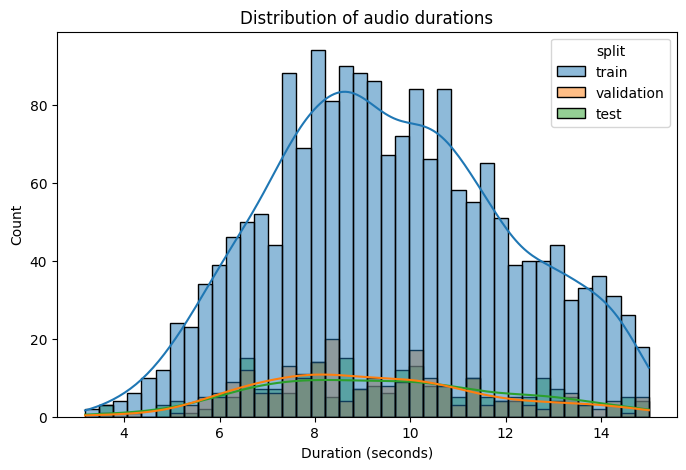

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_train["split"] = "train"
df_val["split"] = "validation"
df_test["split"] = "test"
df_all = pd.concat([df_train, df_val, df_test])

plt.figure(figsize=(8,5))
sns.histplot(df_all, x="duration_sec", hue="split", bins=40, kde=True)
plt.title("Distribution of audio durations")
plt.xlabel("Duration (seconds)")
plt.show()


/tmp/ipython-input-748374153.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["word_count"] = df_train["text"].apply(lambda x: len(str(x).split()))


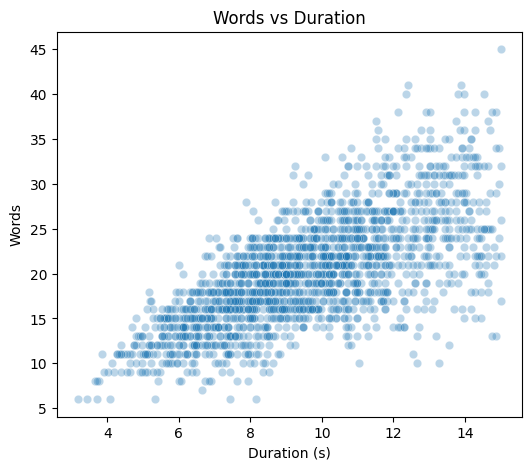

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
df_train["word_count"] = df_train["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,5))
sns.scatterplot(x="duration_sec", y="word_count", data=df_train, alpha=0.3)
plt.xlabel("Duration (s)")
plt.ylabel("Words")
plt.title("Words vs Duration")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


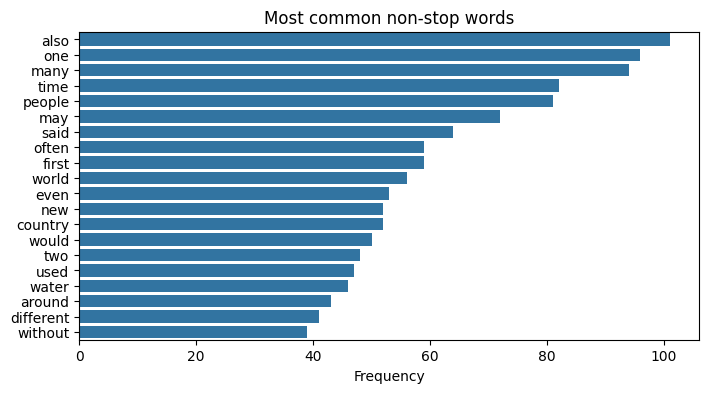

In [47]:
from collections import Counter
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("english"))

words = " ".join(df_train["text"]).split()
filtered = [w for w in words if w not in STOPWORDS]
counts = Counter(filtered)
common = counts.most_common(20)

plt.figure(figsize=(8,4))
sns.barplot(y=[c[0] for c in common], x=[c[1] for c in common], orient="h")
plt.title("Most common non-stop words")
plt.xlabel("Frequency")
plt.show()


In [48]:
print(df_all["duration_sec"].describe())


count    2355.000000
mean        9.529792
std         2.492950
min         3.180000
25%         7.680000
50%         9.360000
75%        11.280000
max        15.000000
Name: duration_sec, dtype: float64


In [49]:
print("Shortest:", df_train.loc[df_train['duration_sec'].idxmin()]["text"])
print("Longest:", df_train.loc[df_train['duration_sec'].idxmax()]["text"])


Shortest: no one was inside the apartment
Longest: this is because electricity flowing into the socket where the metallic part of bulb sits can give you a severe electric shock if you touch the inside of the socket or the metal base of the bulb while it is still partly in the socket


/tmp/ipython-input-2368090633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["duration_group"] = pd.qcut(df_train["duration_sec"], q=4, labels=["short", "medium", "long", "very long"])
/tmp/ipython-input-2368090633.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="duration_group", y="word_count", data=df_train, palette="Set2")


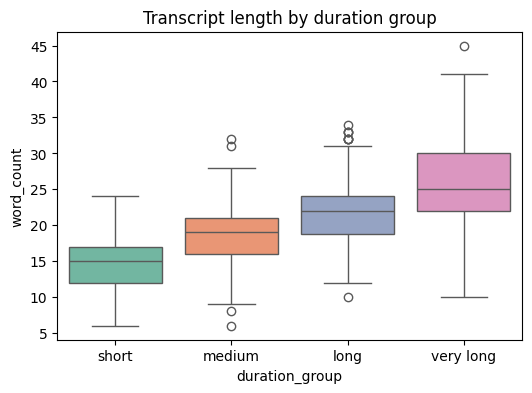

In [50]:
df_train["duration_group"] = pd.qcut(df_train["duration_sec"], q=4, labels=["short", "medium", "long", "very long"])

plt.figure(figsize=(6,4))
sns.boxplot(x="duration_group", y="word_count", data=df_train, palette="Set2")
plt.title("Transcript length by duration group")
plt.show()


**Model**

In [ ]:
from datasets import DatasetDict, Dataset, Audio
from transformers import WhisperProcessor
import os
import pandas as pd

BASE_DIR = "fleurs_preview"

audio_files = sorted([f for f in os.listdir(BASE_DIR) if f.endswith(".wav")])

data = []
for wav in audio_files:
    txt_path = os.path.join(BASE_DIR, wav + ".txt")
    if not os.path.exists(txt_path):
        continue
    with open(txt_path, "r", encoding="utf-8") as f:
        text = f.read().strip()
    data.append({"audio": os.path.join(BASE_DIR, wav), "text": text})

df_all = pd.DataFrame(data)
print(f"Found {len(df_all)} audio–text pairs.")

n = len(df_all)
train_end = int(0.8 * n)
val_end = int(0.9 * n)
df_train = df_all.iloc[:train_end]
df_val   = df_all.iloc[train_end:val_end]


ds_all = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "validation": Dataset.from_pandas(df_val.reset_index(drop=True))
})

ds_all = ds_all.cast_column("audio", Audio(decode=True))

processor = WhisperProcessor.from_pretrained("openai/whisper-small.en")

def prepare_example(batch):
    audio = batch["audio"]
    inputs = processor.feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt"
    )
    labels = processor.tokenizer(batch["text"], return_tensors="pt")
    batch["input_features"] = inputs.input_features[0]
    batch["labels"] = labels.input_ids[0]
    return batch

ds_prepared = ds_all.map(prepare_example)

print(ds_prepared)


Found 26 audio–text pairs.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'input_features', 'labels'],
        num_rows: 20
    })
    validation: Dataset({
        features: ['audio', 'text', 'input_features', 'labels'],
        num_rows: 3
    })
})


In [52]:
ds_prepared["train"][0]["audio"]

{'path': None,
 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.05175781e-05, -3.05175781e-05, -3.05175781e-05]),
 'sampling_rate': 16000}

In [53]:
ds_prepared["train"][0]["text"]

'a tornado is a spinning column of very low-pressure air which sucks the surrounding air inward and upward'

In [54]:
from IPython.display import Audio as IPyAudio
IPyAudio(ds_prepared["train"][0]["audio"]["array"], rate=ds_prepared["train"][0]["audio"]["sampling_rate"])

In [55]:
import torch
import evaluate
from dataclasses import dataclass
from typing import Dict, List, Union
from transformers import (
    WhisperForConditionalGeneration,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
)


In [56]:
MODEL_ID = "openai/whisper-small.en"

In [57]:
forced_ids = processor.get_decoder_prompt_ids(language="en", task="transcribe")

In [58]:
model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID)
model.config.forced_decoder_ids = forced_ids
model.generation_config.forced_decoder_ids = forced_ids
model.config.suppress_tokens = []
model.generation_config.suppress_tokens = []
model.config.use_cache = False
model.config.pad_token_id = processor.tokenizer.pad_token_id

In [59]:
for p in model.model.encoder.parameters():
    p.requires_grad = False

In [ ]:
@dataclass
class DataCollatorWhisper:
    label_pad_token_id: int = -100

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        feats = [torch.tensor(f["input_features"]) for f in features]    
        batch = {"input_features": torch.stack(feats)}                    

        pad_id = processor.tokenizer.pad_token_id
        labs = [torch.tensor(f["labels"], dtype=torch.long) for f in features]
        max_len = max(t.numel() for t in labs)
        y = torch.full((len(labs), max_len), pad_id, dtype=torch.long)
        for i, t in enumerate(labs):
            y[i, : t.numel()] = t
        y[y == pad_id] = self.label_pad_token_id
        batch["labels"] = y
        return batch


In [61]:
data_collator = DataCollatorWhisper()

In [62]:
!pip install jiwer

In [63]:
wer = evaluate.load("wer")
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    labels = torch.tensor(labels)
    labels[labels == -100] = processor.tokenizer.pad_token_id
    pred_str = processor.tokenizer.batch_decode(torch.tensor(preds), skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
    pred_str = [s.strip().lower() for s in pred_str]
    label_str = [s.strip().lower() for s in label_str]
    return {"wer": wer.compute(predictions=pred_str, references=label_str)}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="whisper-ft",
    per_device_train_batch_size=8,        
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=1e-4,
    num_train_epochs=15,                    
    warmup_steps=50,
    logging_steps=5,
    eval_strategy="steps",
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    predict_with_generate=True,
    generation_max_length=225,
    fp16=torch.cuda.is_available(),
    gradient_checkpointing=True,
    report_to="none",
)

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=ds_prepared["train"],
    eval_dataset=ds_prepared["validation"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,   
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-3655342594.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [65]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
10,1.062000,0.870310,0.112903
20,0.014800,0.352684,0.145161
30,0.000300,0.439996,0.177419
40,0.000100,0.473550,0.193548


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': []}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be N

TrainOutput(global_step=45, training_loss=0.3496148151064214, metrics={'train_runtime': 244.6278, 'train_samples_per_second': 1.226, 'train_steps_per_second': 0.184, 'total_flos': 8.6575620096e+16, 'train_loss': 0.3496148151064214, 'epoch': 15.0})

In [66]:
metrics = trainer.evaluate()
print("Eval metrics:", metrics)

Eval metrics: {'eval_loss': 0.475821316242218, 'eval_wer': 0.1935483870967742, 'eval_runtime': 1.3894, 'eval_samples_per_second': 2.159, 'eval_steps_per_second': 0.72, 'epoch': 15.0}


In [67]:
ex = ds_prepared["validation"][0]
inp = torch.tensor(ex["input_features"]).unsqueeze(0).to(model.device)
with torch.no_grad():
    gen_ids = model.generate(inp, max_length=225, num_beams=1)
pred = processor.tokenizer.decode(gen_ids[0], skip_special_tokens=True)
ref  = processor.tokenizer.decode(torch.tensor(ex["labels"]).tolist(), skip_special_tokens=True)
print("PRED:", pred)
print("REF :", ref)

PRED: you and peacekeepers who arrived in hady after the 2010 earthquake are being blamed for the spread of the disease which started near the troops encampment.
REF : un peacekeepers whom arrived in haiti after the 2010 earthquake are being blamed for the spread of the disease which started near the troop's encampment


In [68]:
save_dir = "whisper-ft-final"
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)
print(f"Saved to ./{save_dir}")

Saved to ./whisper-ft-final
